<a href="https://colab.research.google.com/github/mvadrev/coviScan/blob/main/coviScan_top_results_with_paths_unfinished_5_17_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip
!pip install lime
!pip install timm https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip
!pip install pydub
!pip install pedalboard


     / 297 kB 3.9 MB/s
     |████████████████████████████████| 431 kB 15.7 MB/s 
  Created wheel for torchsampler: filename=torchsampler-0.1.1-py3-none-any.whl size=3838 sha256=909f9920ea69250eabb7872506aab9a4924c73c858f49315ec4a1825647787de
  Stored in directory: /tmp/pip-ephem-wheel-cache-3gz8zam6/wheels/52/7b/7d/ce0e0ddbb7864877a0e31a96f883a928791ebfa6eaf7b52f87
Successfully built torchsampler
     |████████████████████████████████| 275 kB 13.8 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=047e8ef73ee567c7c8ebbc7d4fe6a90cddfd714a70a8a2106d252c59995e0b2f
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
  Using cached https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip
     |████████████████████████████████| 5.0 MB 15.3 MB/s 


In [2]:
import os 
import shutil
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from collections import Counter
import math

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle
import tqdm.notebook as tqdm
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.nn import functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn import decomposition
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import timm 
import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [3]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: content/data3/
   creating: content/data3/positive/
 extracting: content/data3/positive/0drfnqVwccT6UmgVLQEuyVglDC23_cough-heavy.wav.png  
 extracting: content/data3/positive/UoUR3jonNScKDHaH8HVDKAEeTpj2_cough-heavy.wav.png  
 extracting: content/data3/positive/kAnUnZf9b6d4bkjJCawv0nCGJUI2_cough-heavy.wav.png  
 extracting: content/data3/positive/ZaTgRbDWn9d1MMPanam0NCupVCl1_cough-heavy.wav.png  
 extracting: content/data3/positive/373AihVhKDYxeUR24zNi11JavqC3_cough-shallow.wav.png  
 extracting: content/data3/positive/ffXE7VADnca3RAVTmQd60PrIRfk2_cough-heavy.wav.png  
 extracting: content/data3/positive/iowFPDECVScrXnuQUdAzFR5lZTn2_cough-shallow.wav.png  
 extracting: content/data3/positive/8Oot6FsWpdgyMs1eXi5PeTlHkO22_cough-heavy.wav.png  
 extracting: content/data3/positive/FLNZB0Us1PgOdXLJUC4tmsvRrH43_cough-heavy.wav.png  
 extracting: content/data3/positive/1C6BCvPkrjT62P0843qRIsRPClF2_cough-heavy.wav.png  
 extracting: content/data3/positi

In [4]:
# Set randonm seed for resproducibility
random.seed(1234)
np.random.seed(1234)
data_dir = "/content/data3"
images_dir = os.path.join(data_dir, 'images')
image_files = glob.glob(images_dir+'/*/*')
labels = []
for file_name in image_files:
  labels.append(file_name.split("/")[4])
img_df = pd.DataFrame({'images':image_files, 'labels':labels})
img_df.head()


,images,labels
0,/content/data3/images/healthy/fVL3e9RKRgN2yNKT...,healthy
1,/content/data3/images/healthy/2bQap3Ev6AYxMG1p...,healthy
2,/content/data3/images/healthy/stnT0xsBXhb159fZ...,healthy
3,/content/data3/images/healthy/22oBvWaWwBhbdNfW...,healthy
4,/content/data3/images/healthy/4atnIFwUK3ZZTiWe...,healthy


In [5]:
# Split dataset into train , test and validation
train, test = train_test_split(img_df, stratify=img_df.labels, test_size=0.1, random_state=42)
train, valid = train_test_split(train, stratify=train.labels, test_size=0.1, random_state=42)

In [6]:
#creating train, test and validation directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)
os.makedirs(val_dir)

classes = os.listdir(images_dir)
print("There are",classes,"in the data")

for c in classes:   
    train_filter = train[train.labels==c]
    test_filter = test[test.labels==c]
    val_filter = valid[valid.labels==c]

    train_filter_images = train_filter.images.tolist()
    test_filter_images = test_filter.images.tolist()
    val_filter_images = val_filter.images.tolist()

    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    os.makedirs(os.path.join(val_dir, c), exist_ok = True)

    for image in train_filter_images:

        image_name = image.split("/")[5]
        image_dst = os.path.join(train_dir, c, image_name) 
        shutil.copyfile(image, image_dst)
        
    for image in test_filter_images:
        image_name = image.split("/")[5]
        image_dst = os.path.join(test_dir, c, image_name) 
        shutil.copyfile(image, image_dst)

    for image in val_filter_images:
        image_name = image.split("/")[5]
        image_dst = os.path.join(val_dir, c, image_name) 
        shutil.copyfile(image, image_dst)

There are ['healthy', 'positive'] in the data


In [7]:
class CFG:

  epochs =25                          
  lr = 0.001                           
  batch_size = 16                      
  img_size = 224                       

  # going to be used for loading dataset
  train_path='/content/data3/train'
  validate_path='/content/data3/val'
  test_path='/content/data3/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [8]:
#transforming images
train_transform = transforms.Compose([  
                             transforms.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             transforms.RandomHorizontalFlip(),
                             transforms.RandomVerticalFlip(),
                             transforms.RandomRotation(degrees=(-10,+10)), 
                             transforms.ToTensor(),  
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 

])

validate_transform = transforms.Compose([  
                             transforms.Resize(size=(CFG.img_size,CFG.img_size)), 
                             transforms.ToTensor(), 
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 
])

test_transform = transforms.Compose([ 
                             transforms.Resize(size=(CFG.img_size,CFG.img_size)), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 

])


In [20]:
import torch
from torchvision import datasets
# Credits to https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# EXAMPLE USAGE:
# instantiate the dataset and dataloader
data_dir = "/content/data3/test"
dataset = ImageFolderWithPaths(data_dir, transform=test_transform) # our custom dataset
dataloader = torch.utils.data.DataLoader(dataset)

# iterate over data
for j, (images, labels, paths) in enumerate(dataloader):
    # use the above variables freely
    print(labels, paths)

tensor([0]) ('/content/data3/test/healthy/0M4YhLM7FwWO5IjCqhi7MlBhvJv2_cough-heavy.wav.png',)
tensor([0]) ('/content/data3/test/healthy/0bcMNFt3dlPlUPTyCO8DVAlbTUC3_cough-heavy.wav.png',)
tensor([0]) ('/content/data3/test/healthy/0mkAUAbpROMIFjKpdFxlUnYTV262_cough-shallow.wav.png',)
tensor([0]) ('/content/data3/test/healthy/2JEOCn5AtuQh5Skzhzf5ASuIC9z1_cough-heavy.wav.png',)
tensor([0]) ('/content/data3/test/healthy/2jy59FeBfYd59GJ6zn6PvLGloD83_cough-heavy.wav.png',)
tensor([0]) ('/content/data3/test/healthy/2suYua5dbdh2cSreNFm8flktMEc2_cough-shallow.wav.png',)
tensor([0]) ('/content/data3/test/healthy/2zAfpSxYt0O6Bl7qwUhicdCoyY42_cough-shallow.wav.png',)
tensor([0]) ('/content/data3/test/healthy/2zDWjtjSxeUuy2or5XThZNSzvwO2_cough-heavy.wav.png',)
tensor([0]) ('/content/data3/test/healthy/3LCqXTY14jROmsMpG3XkEiMJ9cD3_cough-shallow.wav.png',)
tensor([0]) ('/content/data3/test/healthy/4VglD8545bYRUyNLgqC0dy8roVo2_cough-shallow.wav.png',)
tensor([0]) ('/content/data3/test/healthy/4w3GC0eR

In [36]:
trainset=ImageFolderWithPaths(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

validateset=ImageFolderWithPaths(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

testset=ImageFolderWithPaths(CFG.test_path,transform=test_transform)
print("testset Size:  {}".format(len(testset)))

Trainset Size:  2273
validateset Size:  253
testset Size:  281


In [37]:
trainloader = data.DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  3101 / batch_size: 16 = 194(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = data.DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  345 / batch_size: 16 = 22(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = data.DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  383 / batch_size: 16 = 24(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:143
No. of Total examples:2273
No. of batches in validationloader:16
No. of Total examples:253
No. of batches in testloader:18
No. of Total examples:281


In [38]:
def computeTestSetAccuracy(model, criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Set to evaluation mode
    model.eval()

    # Validation loop
    y_pred_list = []
    y_true_list = []
    for j, (images, labels, paths) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass - compute outputs on input data using the model
        logits = model(images)

        y_true_list.append(labels.data.to("cpu").tolist())
        #y_pred_list.append(logits.to("cpu").tolist())
        y_pred = F.softmax(logits,dim = 1)
        top_p,top_class = y_pred.topk(1,dim = 1)
        y_pred_list.append(top_class.data.to("cpu").tolist())

        loss = criterion(logits,labels)
        test_loss += loss.item()
        test_acc += accuracy(logits,labels)

    return y_pred_list, y_true_list


In [39]:
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['NORMAL', 'POSITIVE']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [40]:
# Load effNet saved model
model_name = 'efficientnetv2_rw_m'
import tqdm.notebook as tqdm

efficientnetv2_model = timm.create_model(model_name,pretrained=True) #load pretrained model
# Freeze model parameters
for param in efficientnetv2_model.parameters():
  param.requires_grad = False

# Change the final layer of Efficientnetv2 Model for Transfer Learning
#we are updating it as a 2-class classifier:
efficientnetv2_model.classifier = nn.Sequential(
    nn.Linear(in_features=2152, out_features=625), #2152 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

# as we are training on GPU. Convert model to be used on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnetv2_model.to(device) # move the model to GPU
efficientnetv2_model.load_state_dict(torch.load('/content/effnet.pt'))
efficientnetv2_model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): Identity()
        (conv_pwl): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): I

In [45]:
class COVIDTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
        self.history = []
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm.tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validationloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels, paths in tqdm.tqdm(validationloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validationloader), valid_acc / len(validationloader)
            
        
    def fit(self,model,trainloader,validationloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validationloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ColabCovidModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))
            self.history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        return self.history

In [46]:
def computeTestSetAccuracy(model, criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Set to evaluation mode
    model.eval()

    # Validation loop
    y_pred_list = []
    y_true_list = []
    for j, (images, labels, paths) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass - compute outputs on input data using the model
        logits = model(images)

        y_true_list.append(labels.data.to("cpu").tolist())
        #y_pred_list.append(logits.to("cpu").tolist())
        y_pred = F.softmax(logits,dim = 1)
        top_p,top_class = y_pred.topk(1,dim = 1)
        y_pred_list.append(top_class.data.to("cpu").tolist())

        loss = criterion(logits,labels)
        test_loss += loss.item()
        test_acc += accuracy(logits,labels)

    return y_pred_list, y_true_list


In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnetv2_model.parameters(),lr = CFG.lr)
trainer= COVIDTrainer(criterion,optimizer)

In [48]:
avg_test_loss_effNet, avg_test_acc_effNet = trainer.valid_batch_loop(efficientnetv2_model,testloader)


print("Test Loss : {}".format(avg_test_loss_effNet))
print("Test Acc : {}".format(avg_test_acc_effNet))

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

y_pred_list, y_true_list = computeTestSetAccuracy(efficientnetv2_model, criterion)

y_pred_list_effNet = [j for i in y_pred_list for j in i]
y_true_list_effNet = [j for i in y_true_list for j in i]

print(classification_report(y_true_list_effNet, y_pred_list_effNet, digits=3))

  0%|          | 0/18 [00:00<?, ?it/s]

Test Loss : 0.5521326495541466
Test Acc : 0.6994598507881165
              precision    recall  f1-score   support

           0      0.667     0.828     0.738       145
           1      0.752     0.559     0.641       136

    accuracy                          0.698       281
   macro avg      0.710     0.693     0.690       281
weighted avg      0.708     0.698     0.691       281



In [ ]:
len(testloader.dataset.samples)

281

In [49]:
# gt individual predictions

def computeTestAccuracyIndividually(model, criterion):

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  test_acc = 0.0
  test_loss = 0.0

  # Set to evaluation mode
  model.eval()

  # Validation loop
  y_pred_list = []
  y_true_list = []
  for j, (images, labels, paths) in enumerate(testloader):
      print("Iterating file",j)
      print("The len of lables", len(labels))
      # print("The labels is", labels[j])
      images = images.to(device)
      labels = labels.to(device).ToTensor()
      sample_fname, _ = testloader.dataset.samples[j]
      print(sample_fname)

      # Forward pass - compute outputs on input data using the model
      logits = model(images)

      y_true_list.append(labels.data.to("cpu").tolist())
      #y_pred_list.append(logits.to("cpu").tolist())
      y_pred = F.softmax(logits,dim = 1)
      top_p,top_class = y_pred.topk(1,dim = 1)
      y_pred_list.append(top_class.data.to("cpu").tolist())
      

      loss = criterion(logits,labels)

      print("The loss is", loss.item())
      print("The accuracy is", accuracy(logits,labels))

  return labels






In [52]:
for j, (images, labels, paths) in enumerate(testloader):
      print("Iterating file",j)
      print("The len of lables", len(labels))
      # print("The labels is", labels[j])
      images = images.to(device)
      print(labels)
      labels = torch.tensor(labels.to(device))

      print(paths)
      break
      sample_fname, _ = testloader.dataset.samples[j]
      print(sample_fname)

      # Forward pass - compute outputs on input data using the model
      logits = efficientnetv2_model(images)

      y_pred = F.softmax(logits,dim = 1)
      top_p,top_class = y_pred.topk(1,dim = 1)
      y_pred_list.append(top_class.data.to("cpu").tolist())
      

      loss = criterion(logits,labels)

      print("The loss is", loss.item())
      print("The accuracy is", accuracy(logits,labels))

Iterating file 0
The len of lables 16
tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1])
('/content/data3/test/positive/6yut3EO9tXPCCY8O0VDWA5PCWYN2_cough-shallow.wav.png', '/content/data3/test/positive/Vs8uBCHBz3eNp8HeOdbnDoG4RJT2_cough-heavy.wav.png', '/content/data3/test/healthy/CKQpcw70anZK0rg63buUPt2FlhB3_cough-shallow.wav.png', '/content/data3/test/positive/Zmjv6hT2Q1VfJhGdGh9VkGmpHL03_cough-shallow.wav.png', '/content/data3/test/healthy/an56VxZWQ5RKFCHxW3Y0NquAEcA3_cough-shallow.wav.png', '/content/data3/test/positive/BG1rEPoPYKUAHCYVzPrcB3I6VUn2_cough-heavy.wav.png', '/content/data3/test/positive/EH7I0GkUTxaarHEJYy93KjAyqCK2_cough-shallow.wav.png', '/content/data3/test/positive/iowFPDECVScrXnuQUdAzFR5lZTn2_cough-heavy.wav.png', '/content/data3/test/healthy/jkP5JFFckOVBrO7AaRcacyXkgMk1_cough-shallow.wav.png', '/content/data3/test/healthy/g6wE0LPtHWdH7XAWDCGHB5Kj1So1_cough-heavy.wav.png', '/content/data3/test/positive/8Oot6FsWpdgyMs1eXi5PeTlHkO22_cough-heavy.wav.png', '/con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [ ]:
len(testloader.dataset.samples)

281

In [27]:
# checking all labels as below zp.zeros of 32 is not correct
for j, (images, labels) in enumerate(testloader):
      print("Iterating file",j)
      print("The len of lables", len(labels))
      # print("The labels is", labels[j])
      img = images
      images = images.to(device)
      print("labels",labels.shape)
      labels = torch.tensor(labels.to(device='cuda'))
      # sample_fname, _ = testloader.dataset.samples[j]
      # print(sample_fname)     

      for i in range(images.shape[0]):
        sample_fname = testloader.ImageFolder.samples[j][0] 
        print(sample_fname)
        sample_fname, _ = testloader.dataset.samples[i]
      # Forward pass - compute outputs on input data using the model
        # d = np.array(np.full(32, img[i]))
        logits = efficientnetv2_model(images[i].unsqueeze(0).expand(32, 3, -1, -1).to(device='cuda'))
        # logits = efficientnetv2_model(d)


        y_pred = F.softmax(logits,dim = 1)
        top_p,top_class = y_pred.topk(1,dim = 1)
        y_pred_list.append(top_class.data.to("cpu").tolist())
        

        print("labels ********", labels[i].cpu().detach().numpy())
        # newLabels = torch.tensor([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]).to(device='cuda')
        newlabels = torch.tensor(np.full(32,labels[i].cpu().detach().numpy())).to(device='cuda')
        loss = criterion(logits,newlabels)
        print("The loss is", loss.item())
        print("The accuracy is", accuracy(logits,newlabels))
      print("####### End of batch #######")

Iterating file 0
The len of lables 16
labels torch.Size([16])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


AttributeError: ignored

In [ ]:

list = testloader.dataset.samples
import PIL
for i in range(len(testloader.dataset.samples)):
  sample_fname, _ = testloader.dataset.samples[i]
  print(sample_fname)
  img = sample_fname
  image = PIL. Image. open(img)
  model = efficientnetv2_model
  transform = transforms.Compose([transforms.ToTensor()])
  tensor = transform(image).unsqueeze(0).expand(32, 3, -1, -1).to(device='cuda')
  print(tensor.shape)
  logits = model(tensor)
  labels= [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  labels = torch.tensor(labels).to(device)
  loss = criterion(logits,labels)

  print("The loss is", loss.item())
  print("The accuracy is", accuracy(logits,labels))


/content/data3/test/healthy/0KOy96zEUfdMY4rZzwrDT0gMPDa2_cough-heavy.wav.png
torch.Size([32, 3, 128, 210])
The loss is 0.49831387400627136
The accuracy is tensor(1.)
/content/data3/test/healthy/0zAgZhOXaGhmL1SnhkzJOIoowKg2_cough-shallow.wav.png
torch.Size([32, 3, 128, 254])
The loss is 0.473060667514801
The accuracy is tensor(1.)
/content/data3/test/healthy/1CtdDsZvTshuIGrVGvF9pilcHP13_cough-shallow.wav.png
torch.Size([32, 3, 128, 295])
The loss is 0.47774699330329895
The accuracy is tensor(1.)
/content/data3/test/healthy/1G9prDQSP1fpNL0yc7C6Rqy7jmK2_cough-shallow.wav.png
torch.Size([32, 3, 128, 145])
The loss is 0.47925353050231934
The accuracy is tensor(1.)
/content/data3/test/healthy/1gimjLEgqBdoHReixdq8HlEBfEr2_cough-shallow.wav.png
torch.Size([32, 3, 128, 129])
The loss is 0.5045328736305237
The accuracy is tensor(1.)
/content/data3/test/healthy/3LCqXTY14jROmsMpG3XkEiMJ9cD3_cough-shallow.wav.png
torch.Size([32, 3, 128, 210])
The loss is 0.4672890305519104
The accuracy is tensor(1.

In [ ]:
model.parameters

<bound method Module.parameters of EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): Identity()
        (conv_pwl): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1):

0

In [ ]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
# img = get_image('/content/data3/test/positive/0kFnp420ZNR1jLp0JWCjMGDzvXo2_cough-heavy.wav.png')
# plt.imshow(img)

In [ ]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(size=(CFG.img_size,CFG.img_size))
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [ ]:
def batch_predict(images):
    efficientnetv2_model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    efficientnetv2_model.to(device)
    batch = batch.to(device)
    
    logits = efficientnetv2_model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

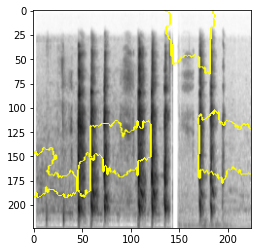

In [ ]:
# Image 1 : Selecting images with best accuracy
# /content/data3/test/healthy/5YSIWpZPYZUqG5rGievs4epu33g2_cough-shallow.wav.png
# The loss is 0.39833614230155945
# The accuracy is tensor(0.9375)
# Healthy
img = get_image('/content/data3/test/healthy/5YSIWpZPYZUqG5rGievs4epu33g2_cough-shallow.wav.png')
# plt.imshow(img)

#test on a single image
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

  0%|          | 0/1000 [00:00<?, ?it/s]

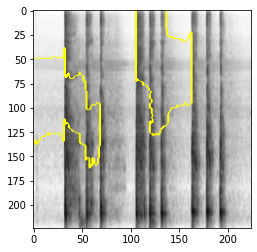

In [ ]:
# Iterating file 7
# The len of lables 16
# /content/data3/test/healthy/3fKAFFPrGTZTay5GlkoipIjRUPL2_cough-heavy.wav.png
# The loss is 0.3744265139102936
# The accuracy is tensor(0.8750)
# Healthy
img = get_image('/content/data3/test/healthy/3fKAFFPrGTZTay5GlkoipIjRUPL2_cough-heavy.wav.png')
# plt.imshow(img)

#test on a single image
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)